In [1]:
# %config InlineBackend.figure_format = 'retina'

from enum import Enum
from typing import TypedDict, List, Tuple
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageFilter


class HeadType(int, Enum):
    PROBLEM = 0  # blue
    TITLE = 1  # black
    CONTINUE = 2  # white


HeadTypeColorMap = {
    HeadType.PROBLEM: 'blue',
    HeadType.TITLE: 'gray',
    HeadType.CONTINUE: 'green',
}


class BaseBlock(TypedDict):
    # [i, j)
    value: Tuple[int]


class Block(BaseBlock):
    head: HeadType

blue_xs: (144, 168)


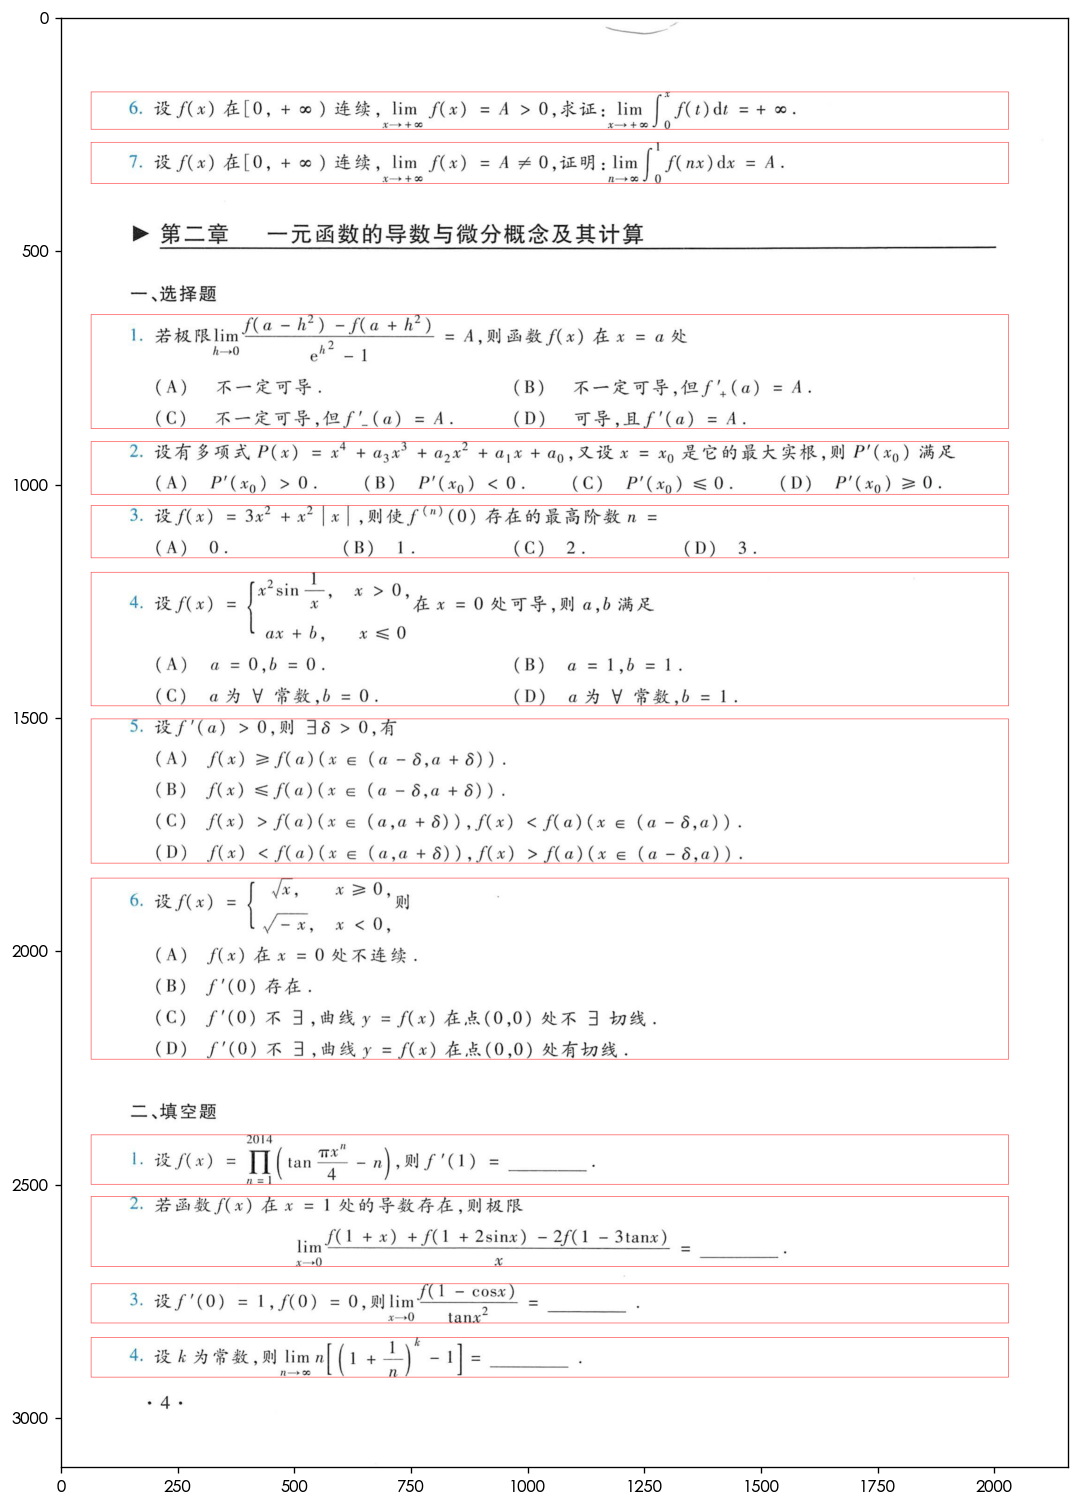

In [30]:
# 一个区块的最小高度，低于这个高度的可能是有噪点的空白行
MIN_BLOCK_HEIGHT = 5

# 判定两个区块之间的最小高度差，低于则合并
# 经过验证，无法通过区块之间的高度差区分大题与小题 :(
# 比9低就不能把一些分子分母粘合一起了，不过可以后续再合并
MIN_HEIGHT_BETWEEN_BLOCKS = 9

# 判断一行是否非空白行的最小有效点数
MIN_NON_WHITE_POINTS_IN_ROW = 1

# 保证block的框选是最佳视觉比例
MARGIN_LEFT_PCT = .03

# 去除页面上下部分的空白
TOP_PCT = .05
BOTTOM_PCT = .95

# 确定题目的标题蓝色位置
MIN_BLUE_X = 100
MAX_BLUE_X = 300

DRAW_BLOCK_TYPE_SQUARE_SIZE = 20

MERGE_CONTUOURS = True

DRAW_BLOCK_TYPE = True
DRAW_BLOCK_YS = False
DRAW_BLOCK_CONTUOUR = True
DRAW_HEIGHT_BETWEEN_BLOCKS = False

QR_MARGIN = 25
QR_RADIUS = 100
QR_PADDING_LEFT = 10
QR_HALF_SIZE = (QR_MARGIN + QR_RADIUS)
QR_BLUR_MIN = 150

FONT = ImageFont.truetype(font='/System/Library/Fonts/PingFang.ttc', size=30)


def is_point_blue(p):
    ans = p[2] / (p[0] + p[1] + 1e-10) * 2 > 1
#     print({"p": p, "ans": ans})
    return ans


def ensure_blue_xs(img):
    data = (255 - np.array(img)) / 255

    def handle_col(col):
        return np.mean(col)

    cols = np.apply_along_axis(handle_col, 0, data)
    ratio = np.apply_along_axis(is_point_blue, 1, cols)
    blue_low = blue_high = None
    for i, j in enumerate(ratio[MIN_BLUE_X:MAX_BLUE_X]):
        if j:
            if not blue_low:
                blue_low = i
            blue_high = i
    assert blue_low and blue_high
    ans = (MIN_BLUE_X + blue_low, MIN_BLUE_X + blue_high)
    print(f'blue_xs: {ans}')
    return ans


def checkHeadType(img, block: Block, blue_xs: Tuple[int]):
    y0, y1 = block['value']
    x0, x1 = blue_xs
    data = np.array(img)[y0:y1, x0:x1] / 255

    val = np.apply_along_axis(is_point_blue, -1, data).mean()
    if val > .05:
        return HeadType.PROBLEM

    if (1-data).mean() < .05:
        return HeadType.CONTINUE

    return HeadType.TITLE


def mergeBlocks(blocks: List[Block]) -> List[Block]:
    out = []
    start = end = None
    isCollecting = False
    for cur in blocks:
        cType = cur['headType']
        if cType == HeadType.PROBLEM:
            if isCollecting:
                out.append({"value": (start, end)})
            start, end = cur['value']
            isCollecting = True
        if cType == HeadType.TITLE:
            if isCollecting:
                out.append({"value": (start, end)})
                isCollecting = False
        if cType == HeadType.CONTINUE:
            if not start:
                start, end = cur['value']
                isCollecting = True
            if isCollecting:
                end = cur['value'][1]
    if isCollecting:
        out.append({"value": (start, end)})
    return out


def dropQrCode(img):
    w, h = img.size
    while True:
        im_blur = img.convert('L').filter(ImageFilter.BoxBlur(QR_RADIUS))
        blur_min = np.min(im_blur)
        if blur_min < QR_BLUR_MIN:
            qr_center = np.unravel_index(np.argmin(im_blur), (h, w))
            y, x = qr_center
            print(f'dropping qrcode at ({x}, {y}), val: {blur_min}')
            qr_start = (x - QR_HALF_SIZE - QR_PADDING_LEFT, y - QR_HALF_SIZE)
            img_white = Image.new(
                'RGB', (QR_HALF_SIZE * 2 + QR_PADDING_LEFT, QR_HALF_SIZE << 1), color=(255, 255, 255))
            img.paste(img_white, qr_start)
        else:
            break


def getBaseBlocks(img) -> List[BaseBlock]:
    w, h = img.size
    # 0: white, 1: others
    data = 1 - np.array(img.convert('1'))
    rows = np.apply_along_axis(lambda row: row.sum(axis=0), 1, data)
    assert rows.shape[0] == h, '对每一行进行二值化累计，因此高度保持不变'
    # print(rows.shape)

    blocks: List[BaseBlock] = []
    start = 0
    is_white = True
    for i, j in enumerate(rows):
        if i < TOP_PCT * h or i > BOTTOM_PCT * h:
            continue
        # 空白结束，内容开始
        if j >= MIN_NON_WHITE_POINTS_IN_ROW and is_white:
            start = i
            is_white = False
        # 内容结束，空白开始
        elif j < MIN_NON_WHITE_POINTS_IN_ROW and not is_white:
            is_white = True
            if i - start >= MIN_BLOCK_HEIGHT:
                if blocks and start - blocks[-1]['value'][1] < MIN_HEIGHT_BETWEEN_BLOCKS:
                    blocks[-1]['value'] = (blocks[-1]['value'][0], i)
                else:
                    blocks.append({"value": (start, i)})
    return blocks


def doDraw(img, blocks: List[Block], blue_xs):
    w, h = img.size
    draw = ImageDraw.Draw(img)
    for block in blocks:
        y0, y1 = block['value']

        if DRAW_BLOCK_YS:
            draw.text(
                (0, y0),
                f'{y0}',
                font=FONT,
                fill='magenta',
                stroke_width=1
            )
            draw.text(
                (0, y1-50),
                f'{y1}',
                font=FONT,
                fill='magenta',
                stroke_width=1
            )

        if DRAW_BLOCK_CONTUOUR:
            draw.rectangle(
                (MARGIN_LEFT_PCT*w, y0, w - MARGIN_LEFT_PCT*w*2, y1),
                outline='red'
            )

        if DRAW_BLOCK_TYPE and not MERGE_CONTUOURS:
            draw.rectangle(
                (MARGIN_LEFT_PCT*w, y0, MARGIN_LEFT_PCT*w +
                 DRAW_BLOCK_TYPE_SQUARE_SIZE, y0+DRAW_BLOCK_TYPE_SQUARE_SIZE),
                fill=HeadTypeColorMap[block['head_type']]
            )

    for p1, p2 in zip(blocks[:-1], blocks[1:]):
        y0, y1 = p2['value']
        ly0, ly1 = p1['value']
        if DRAW_HEIGHT_BETWEEN_BLOCKS:
            draw.text(
                (0, y0-30),
                f'{y0 - ly1}↑',
                font=FONT,
                fill='magenta',
                stroke_width=1
            )


def main(img_path):
    img = Image.open(img_path)
    dropQrCode(img)
    blocks = getBaseBlocks(img)
    blue_xs = ensure_blue_xs(img)
    for block in blocks:
        block['headType'] = checkHeadType(img, block, blue_xs)
    if MERGE_CONTUOURS:
        blocks = mergeBlocks(blocks)
    doDraw(img, blocks, blue_xs)
    plt.figure(figsize=(12,16), dpi=120)
    plt.imshow(img)
    plt.show()


main('../data/images/8.jpg')